In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/leukemia cancer classification

/content/drive/.shortcut-targets-by-id/1ahrfNfv22HZRh0ixUImPPjF0KC5ZzQVa/leukemia cancer classification


# ***General***

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report
from imblearn.metrics import sensitivity_specificity_support
import seaborn as sn
import pandas as pd
from sklearn import metrics

In [4]:
path, dirs, files = next(os.walk("Dataset/train/all"))
file_count = len(files)
print("Apnormal : ",file_count)
path, dirs, files = next(os.walk("Dataset/train/hem"))
file_count = len(files)
print("Normal : ",file_count)

Apnormal :  5965
Normal :  5171


In [5]:
def Read_Dataset(image_size, batch_size):

  train_df = tf.keras.preprocessing.image_dataset_from_directory(
      "Dataset/train",
      image_size = image_size,
      batch_size = batch_size,
  )

  val_df = tf.keras.preprocessing.image_dataset_from_directory(
      "Dataset/val",
      image_size = image_size,
      batch_size = batch_size,
  )

  test_df = tf.keras.preprocessing.image_dataset_from_directory(
      "Dataset/test",
      image_size = image_size,
      batch_size = batch_size,
      shuffle = False,
  )

  train_df = train_df.prefetch(buffer_size = 32)

  val_df = val_df.prefetch(buffer_size = 32)

  y_test = np.concatenate([y for x, y in test_df], axis = 0)

  return train_df, val_df, test_df, y_test

In [6]:
def get_callbacks(model_name):
  callbacks = []

  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = f'model.{model_name}.h5', verbos = 1, monitor = 'val_loss', mode = "min", save_best_only = True, save_freq = "epoch")
  callbacks.append(checkpoint)
  anne = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 5, verbose = 2, min_lr = 0.0000001, min_delta = 0.00001, mode = "auto")
  callbacks.append(anne)
  earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
  callbacks.append(earlystop)

  return callbacks

In [7]:
def Create_Model(model_name, IMG_SHAPE):
  OPTIMIZER = keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)

  if model_name == "MobileNet":
    base_model = tf.keras.applications.MobileNet(input_shape = IMG_SHAPE, include_top = False, weights = "imagenet")
  elif model_name == "Xception":
    base_model = tf.keras.applications.Xception(input_shape = IMG_SHAPE, include_top = False, weights = "imagenet")
  elif model_name == "DenseNet121":
     base_model = tf.keras.applications.DenseNet121(input_shape = IMG_SHAPE, include_top = False, weights = "imagenet")
  elif model_name == "EfficientNetB2":
    base_model = tf.keras.applications.EfficientNetB2(input_shape = IMG_SHAPE, include_top = False, weights = "imagenet")
  elif model_name == "NASNetMobile":
    base_model = tf.keras.applications.NASNetMobile(input_shape = IMG_SHAPE, include_top = False, weights = "imagenet")
  elif model_name == "EfficientNetB4":
    base_model = tf.keras.applications.EfficientNetB4(input_shape = IMG_SHAPE, include_top = False, weights = "imagenet")

  base_model.trainable = True
  x = base_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  predictions = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'Final')(x)
  model = tf.keras.Model(inputs = base_model.input, outputs = predictions)

  model.compile(loss = 'binary_crossentropy', optimizer = OPTIMIZER, metrics = ['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.SpecificityAtSensitivity(0.5), keras.metrics.SensitivityAtSpecificity(.5)])

  return model

In [8]:
def Train_Validation(epoches, acc, val_acc, loss, val_loss):
  plt.plot(epoches, acc, label = 'Training accuarcy')
  plt.plot(epoches, val_acc, label = 'Validation accuarcy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epoches, loss, label = 'Training loss')
  plt.plot(epoches, val_loss, label = 'Validation loss')
  plt.title('Training and Validation loss')
  plt.ylabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

In [9]:
def predict(test_df, y_test):
  y_pred = model.predict(test_df, verbose = 1).round()
  y_pred = y_pred.flatten()
  
  target_names = ['Class Normal', 'Class ApNormal']
  return classification_report(y_test, y_pred, target_names = target_names, digits = 4), y_pred

In [10]:
def Confusion(y_test, y_pred, model_name):
  disp = metrics.confusion_matrix(y_test, y_pred)
  disp.astype('int')
  pd.options.display.float_format = '{:.5f}'.format
  target_names = ['Normal', 'ApNormal']
  df_cm = pd.DataFrame(disp, target_names, target_names)
  fig, ax = plt.subplots(figsize = (4,4))
  sn.set(font_scale = 1.5)
  sn.heatmap(df_cm, annot = True, annot_kws = {"size": 15}, ax = ax, cmap = "YlOrBr", fmt = 'g', cbar = False)
  plt.xlabel('Actual', fontsize = 20)
  plt.ylabel('Predicted', fontsize = 20)
  plt.ioff()
  plt.savefig(f"confusion_mat_{model_name}", bbox_inches = 'tight')
  plt.show()

# Xception


In [ ]:
model_name = "Xception"
train_df, val_df, test_df, y_test = Read_Dataset((224,224),32)

Found 11136 files belonging to 2 classes.
Found 3175 files belonging to 2 classes.
Found 1590 files belonging to 2 classes.


In [ ]:
model = Create_Model("Xception",(224,224,3))
print(model.summary())

83683744/83683744 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                      

In [ ]:
callbacks = get_callbacks("Xception")
history = model.fit(train_df, epochs = 50, validation_data = val_df, callbacks = [callbacks])

Epoch 1/50
155/348 [============>.................] - ETA: 1:50:19 - loss: 0.3355 - accuracy: 0.8607 - precision: 0.8981 - recall: 0.7903 - specificity_at_sensitivity: 0.9977 - sensitivity_at_specificity: 0.9515

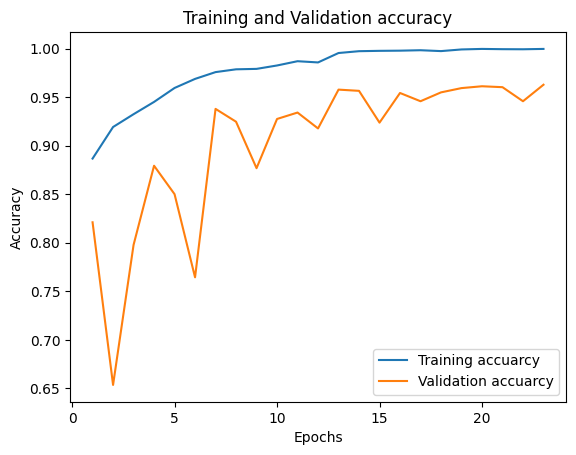

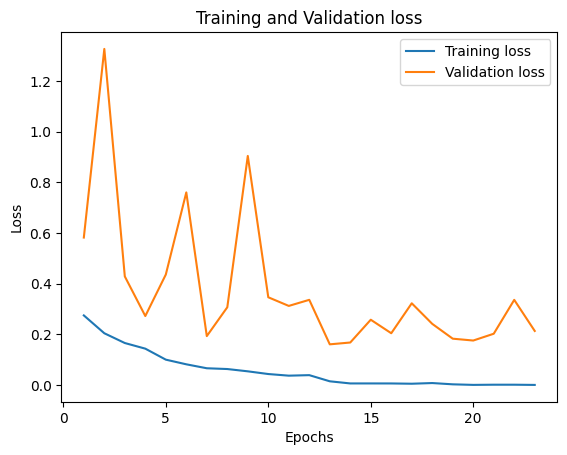

In [ ]:
 acc = history.history['accuracy']
 val_acc = history.history['val_accuracy']
 loss = history.history['loss']
 val_loss = history.history['val_loss']
 epoches = range(1, len(acc) + 1)

Train_Validation(epoches, acc, val_acc, loss, val_loss)

In [ ]:
# model = keras.models.load_model('model.Xception.h5')

In [ ]:
results = model.evaluate(test_df, verbose = 1)

50/50 [==============================] - 18s 149ms/step - loss: 0.2100 - accuracy: 0.9541 - precision: 0.9785 - recall: 0.9216 - specificity_at_sensitivity: 0.9988 - sensitivity_at_specificity: 0.9716


In [ ]:
report, y_pred = predict(test_df, y_test)
print(report)

50/50 [==============================] - 9s 153ms/step
                precision    recall  f1-score   support

  Class Normal     0.9351    0.9824    0.9581       850
Class ApNormal     0.9785    0.9216    0.9492       740

      accuracy                         0.9541      1590
     macro avg     0.9568    0.9520    0.9537      1590
  weighted avg     0.9553    0.9541    0.9540      1590



              precision    recall  f1-score   support

      Normal     0.9351    0.9824    0.9581       850
    ApNormal     0.9785    0.9216    0.9492       740

    accuracy                         0.9541      1590
   macro avg     0.9568    0.9520    0.9537      1590
weighted avg     0.9553    0.9541    0.9540      1590



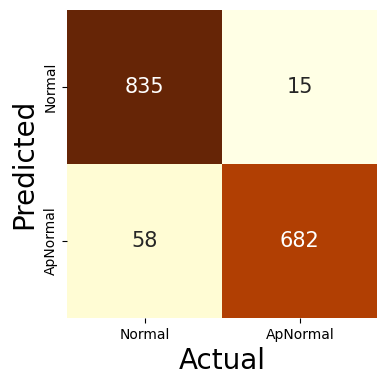

In [ ]:
report = classification_report(y_test, y_pred, target_names = ['Normal', 'ApNormal'], digits = 4)
print(report)

Confusion(y_test, y_pred, model_name)

# DenseNet121

In [11]:
model_name = "DenseNet121"
train_df, val_df, test_df, y_test = Read_Dataset((224,224),32)

Found 11136 files belonging to 2 classes.
Found 3175 files belonging to 2 classes.
Found 1590 files belonging to 2 classes.


In [12]:
model = Create_Model(model_name,(224,224,3))
print(model.summary())

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [13]:
callbacks = get_callbacks(model_name)
history = model.fit(train_df, epochs = 50, validation_data = val_df, callbacks = [callbacks])

Epoch 1/50
348/348 [==============================] - 1459s 4s/step - loss: 0.3555 - accuracy: 0.8465 - precision: 0.8713 - recall: 0.7855 - specificity_at_sensitivity: 0.9970 - sensitivity_at_specificity: 0.9439 - val_loss: 0.9439 - val_accuracy: 0.4910 - val_precision: 0.4774 - val_recall: 0.9959 - val_specificity_at_sensitivity: 0.9882 - val_sensitivity_at_specificity: 0.9364 - lr: 0.0010
Epoch 2/50
348/348 [==============================] - 148s 423ms/step - loss: 0.3003 - accuracy: 0.8719 - precision: 0.8951 - recall: 0.8203 - specificity_at_sensitivity: 0.9990 - sensitivity_at_specificity: 0.9675 - val_loss: 3.5983 - val_accuracy: 0.4652 - val_precision: 0.4652 - val_recall: 1.0000 - val_specificity_at_sensitivity: 0.3781 - val_sensitivity_at_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/50
348/348 [==============================] - 151s 431ms/step - loss: 0.2804 - accuracy: 0.8834 - precision: 0.9097 - recall: 0.8316 - specificity_at_sensitivity: 0.9998 - sensitivity_at_specifici

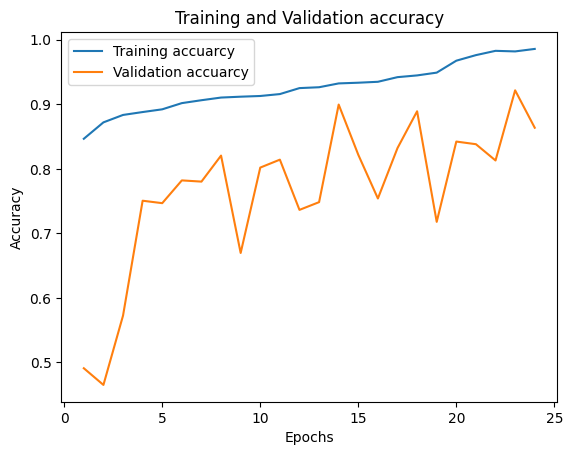

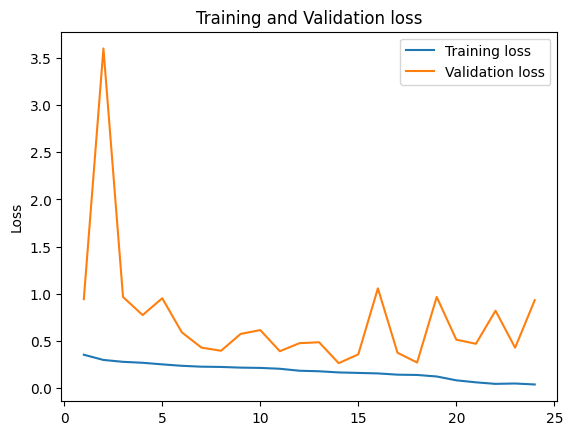

In [14]:
 acc = history.history['accuracy']
 val_acc = history.history['val_accuracy']
 loss = history.history['loss']
 val_loss = history.history['val_loss']
 epoches = range(1, len(acc) + 1)

Train_Validation(epoches, acc, val_acc, loss, val_loss)

In [15]:
# model = keras.models.load_model('model.Xception.h5')

In [16]:
results = model.evaluate(test_df, verbose = 1)

50/50 [==============================] - 12s 231ms/step - loss: 0.9771 - accuracy: 0.8591 - precision: 0.9924 - recall: 0.7027 - specificity_at_sensitivity: 1.0000 - sensitivity_at_specificity: 0.8378


In [17]:
report, y_pred = predict(test_df, y_test)
print(report)

50/50 [==============================] - 11s 180ms/step
                precision    recall  f1-score   support

  Class Normal     0.7936    0.9953    0.8831       850
Class ApNormal     0.9924    0.7027    0.8228       740

      accuracy                         0.8591      1590
     macro avg     0.8930    0.8490    0.8529      1590
  weighted avg     0.8861    0.8591    0.8550      1590



              precision    recall  f1-score   support

      Normal     0.7936    0.9953    0.8831       850
    ApNormal     0.9924    0.7027    0.8228       740

    accuracy                         0.8591      1590
   macro avg     0.8930    0.8490    0.8529      1590
weighted avg     0.8861    0.8591    0.8550      1590



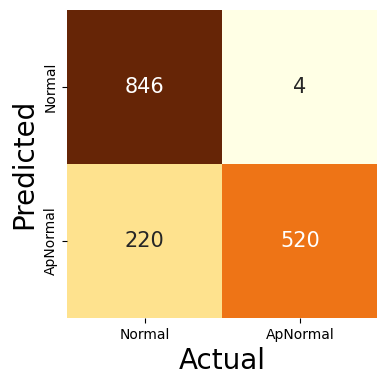

In [18]:
report = classification_report(y_test, y_pred, target_names = ['Normal', 'ApNormal'], digits = 4)
print(report)

Confusion(y_test, y_pred, model_name)